# Load data & convert time to JST

In [2]:
import pandas as pd

def read_act_df(base_dir, time_cols=['Started', 'Finished', 'Updated']):
    """
    Load csv file containing activity data and parse datetime columns.
    Drop rows with NaN in specified time columns.
    Args:
        base_dir (str): Path to the CSV file.
        time_cols (list): List of columns to parse as datetime.
    Returns:
        pd.DataFrame: DataFrame with parsed datetime columns."""
    act_df = pd.read_csv(base_dir)
    act_df = act_df.dropna(subset=time_cols)

    for col in time_cols:
        act_df[col] = pd.to_datetime(act_df[col], format='%Y/%m/%d %H:%M')
        if act_df[col].isna().any():
            raise ValueError(f"Column '{col}' contains NaN or unparseable datetime values.")
        act_df[col] = act_df[col].dt.tz_localize('UTC+09:00')

    return act_df

act_path = '/Users/tptn/MachineLearning/tremor_challenge2/tremor_challenge2/data/TrainingDataPD25/TrainActivities.csv'
act_df = read_act_df(act_path)

In [31]:
import os
import glob

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'
headers = ['id', 'datetime', 'x', 'y', 'z']

def read_users_df(base_dir, headers):
    """
    Load all csv files into one DataFrame.
    Parse datetime and ensure timezone consistency.
    Sort by datetime.
    Args:
        base_dir (str): Base directory containing user data.
        headers (list): List of column names for the DataFrame.
    Returns:
        pd.DataFrame: Concatenated DataFrame with all user data."""
    df_list = [] # to store all csv files
    for id in os.listdir(base_dir):
        path = os.path.join(base_dir, id)

        if os.path.isdir(path):
            files = glob.glob(os.path.join(path, '*.csv'))

            for f in files:
                df = pd.read_csv(f, header=None, names=headers) # load csv
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
                tz = df['datetime'].dt.tz # get the timezone
                if tz != 'UTC+09:00':
                    df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
                df_list.append(df)
    users_df = pd.concat(df_list, ignore_index=True)
    users_df.sort_values(by=['datetime'], inplace=True)
    return users_df

users_df = read_users_df(base_dir, headers)

# Preprocessing

In [109]:
for col in ['ID', 'Started', 'Finished', 'Updated']:
    print(f'{col}: {act_df[col].duplicated().sum()}')

ID: 0
Started: 141
Finished: 140
Updated: 149


## add duration

In [35]:
def add_duration(act_df):
    """Add duration between 'Started' and 'Finished' columns to the activity DataFrame."""
    act_cp = act_df.copy()
    act_cp['Finished'] = act_cp['Finished'].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)
    return act_cp

act_df = add_duration(act_df)

## Segment accerlerometer data for each activity

In [39]:
def seg_acc_per_act(acc_df, act_df):
    seg_list=[]
    seg_label_list=[]
    seg_id_list=[]
    seg_subject_list=[]

    for index, row in act_df.iterrows():
        start = row['Started']
        end = row['Finished']

        seg = acc_df[acc_df['datetime'].between(start, end)]
        seg_id = row['ID']
        seg_label = row['Activity Type']
        seg_subject = row['Subject']
        if not seg.empty:
            seg_list.append(seg)
            seg_label_list.append(seg_label)
            seg_id_list.append(seg_id)
            seg_subject_list.append(seg_subject)

    return seg_list, seg_label_list, seg_id_list, seg_subject_list

seg_list, seg_label_list, seg_id_list, seg_subject_list = seg_acc_per_act(users_df, act_df)

In [ ]:
len(act_df), len(seg_list), len(seg_label_list), len(seg_id_list), len(seg_subject_list)

(275, 271, 271, 271, 271)

In [ ]:
# finding the missing rows
seg_id_set = set(seg_id_list)
missing_rows = act_df[~act_df['ID'].isin(seg_id_set)]
display(missing_rows)

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:59.999999+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:59.999999+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:59.999999+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:59.999999+09:00,2024-09-02 06:20:00+09:00,U22


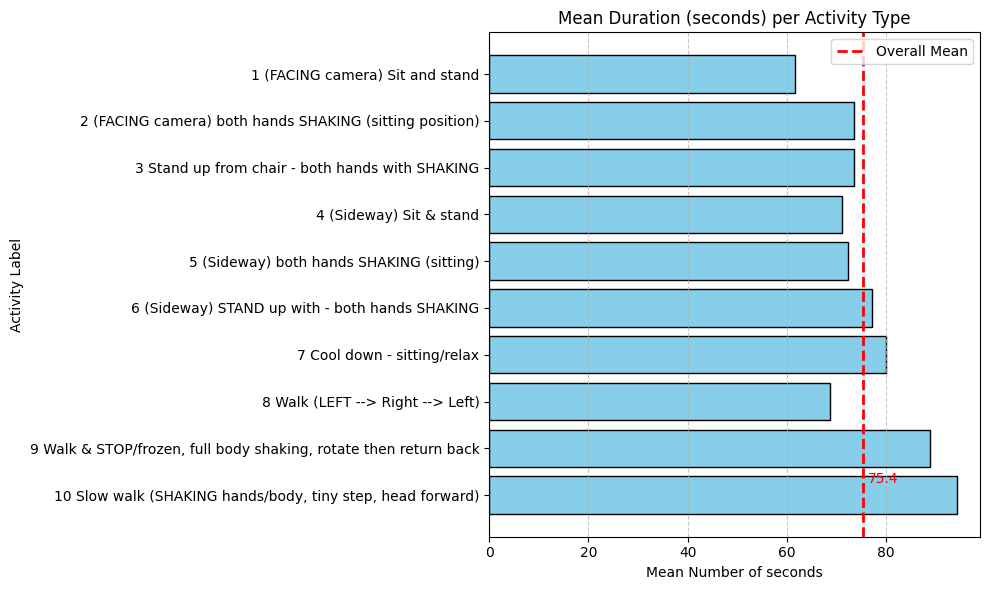

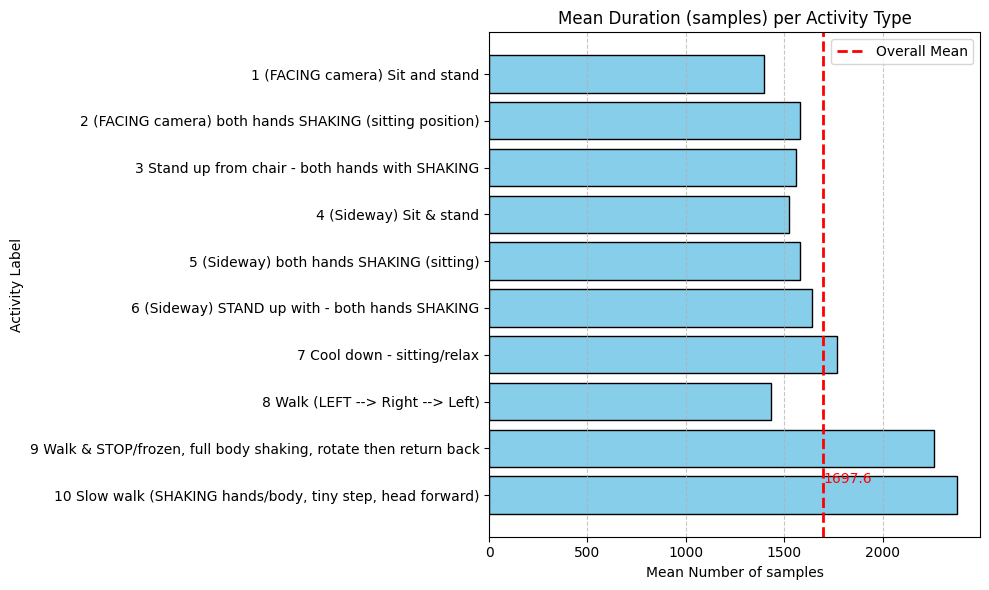

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_mean_duration_per_act(seg_list, seg_label_list, in_time=True):
    """Plot mean duration of segments per activity type.
    Args:
        seg_list (list): List of DataFrames, each representing a segment of accelerometer data.
        seg_label_list (list): List of labels corresponding to each segment in seg_list.
    """
    # Step 1: Compute durations per segment
    if in_time:
        unit = 'seconds'
        durations = [(df['datetime'].max() - df['datetime'].min()).total_seconds() for df in seg_list]
    else:
        unit = 'samples'
        durations = [len(df) for df in seg_list]

    # Step 2: Build DataFrame
    df = pd.DataFrame({
        'label': seg_label_list,
        'duration': durations
    })

    # Step 3: Extract numeric part of label
    df['label_num'] = df['label'].apply(lambda x: int(re.match(r'\d+', str(x)).group()))

    # Step 4: Compute mean duration per activity (based on label number)
    mean_durations = df.groupby(['label_num', 'label'])['duration'].mean().reset_index()

    # Step 5: Sort by label number
    mean_durations = mean_durations.sort_values('label_num', ascending=False)

    # Step 6: Compute overall mean
    overall_mean = df['duration'].mean()

    # Step 7: Plot (horizontal bar chart)
    plt.figure(figsize=(10, 6))
    plt.barh(mean_durations['label'], mean_durations['duration'], color='skyblue', edgecolor='black')

    # Add vertical line for overall mean
    plt.axvline(overall_mean, color='red', linestyle='--', linewidth=2, label='Overall Mean')
    plt.text(overall_mean + 1, 0.2, f'{overall_mean:.1f}', color='red', va='bottom')

    # Labels and layout
    plt.title(f'Mean Duration ({unit}) per Activity Type')
    plt.xlabel(f'Mean Number of {unit}')
    plt.ylabel('Activity Label')
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_mean_duration_per_act(seg_list, seg_label_list)
plot_mean_duration_per_act(seg_list, seg_label_list, in_time=False)

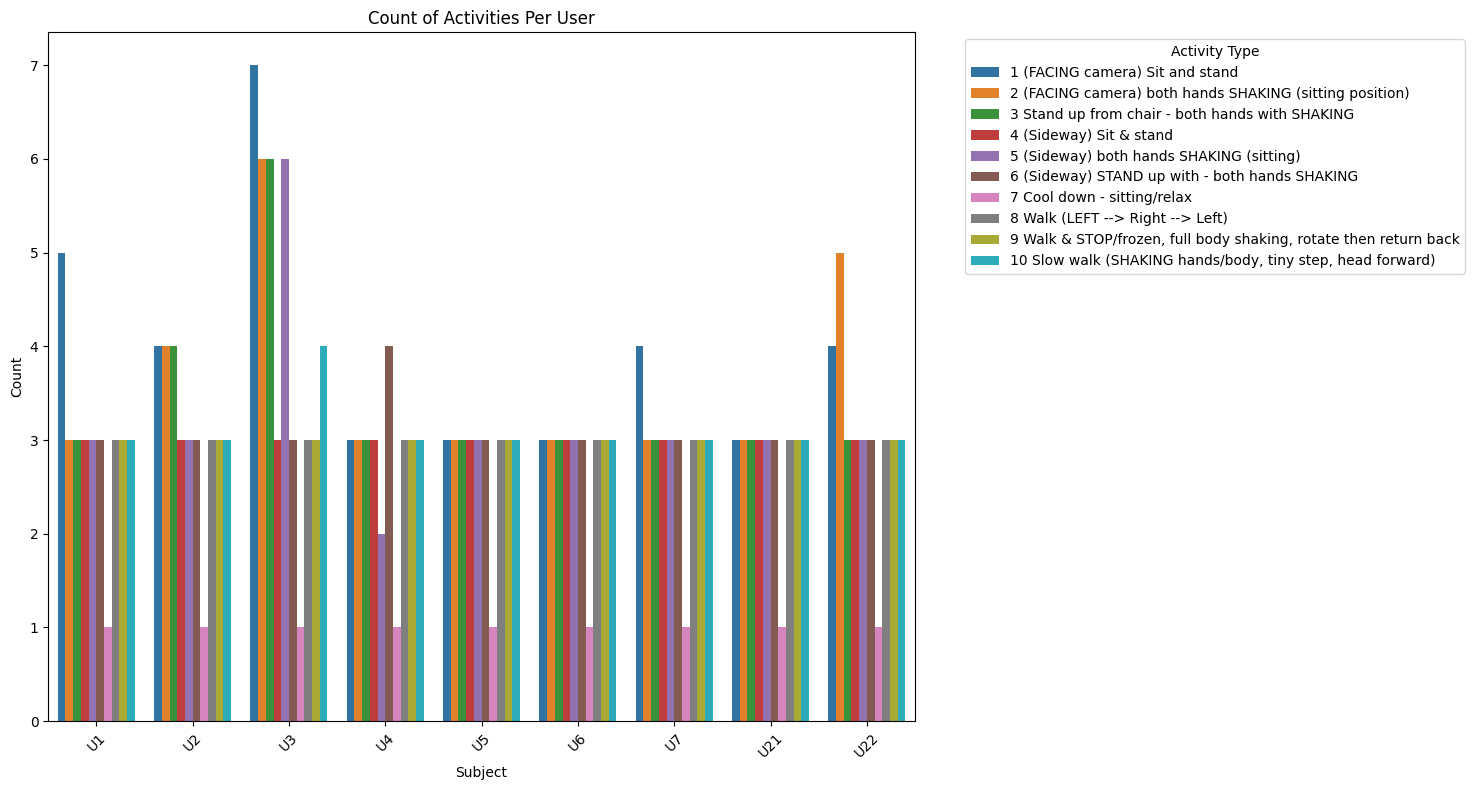

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

def plot_act_count_per_user(df, user_col='Subject', act_col='Activity Type'):
    # Group by Subject and Activity Type, then count occurrences
    activity_counts = df.groupby([user_col, act_col]).size().reset_index(name='Count')

    # Extract numeric part of user and activity
    activity_counts['user_num'] = activity_counts[user_col].apply(lambda x: int(re.search(r'\d+', str(x)).group()))
    activity_counts['act_num'] = activity_counts[act_col].apply(lambda x: int(re.search(r'\d+', str(x)).group()))

    # Sort dataframe by user and activity
    activity_counts = activity_counts.sort_values(['user_num', 'act_num'])

    # Generate sorted order for users and activity types
    sorted_users = activity_counts[user_col].drop_duplicates().tolist()
    sorted_activities = activity_counts[act_col].drop_duplicates().tolist()

    # Plot
    plt.figure(figsize=(15, 8))
    sns.barplot(data=activity_counts, x=user_col, y='Count', hue=act_col,
                order=sorted_users, hue_order=sorted_activities)
    plt.title('Count of Activities Per User')
    plt.xticks(rotation=45)
    plt.legend(title='Activity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_act_count_per_user(act_df)

# Window sliding

## by time

In [6]:
WSIZE = 1 # in seconds
OVERLAP = 0.5 * WSIZE # % of window size
def seg_by_window(seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=1, stride=0.5):
    all_seg_list = []
    all_seg_label_list = []
    all_seg_id_list = []
    all_seg_subject_list = []
    for i in range(len(seg_list)):
        acc_df = seg_list[i]
        start = acc_df['datetime'].min()
        end = acc_df['datetime'].max()
        current = start
        window_count = 0
        if (end - start).total_seconds() < wsize:
            continue
        while current + pd.Timedelta(seconds=wsize) <= end:
            seg = acc_df[acc_df['datetime'].between(current, current + pd.Timedelta(seconds=wsize))]
            if not seg.empty:
                window_count += 1
                all_seg_list.append(seg)
                all_seg_label_list.append(seg_label_list[i])
                all_seg_id_list.append(seg_id_list[i])
                all_seg_subject_list.append(seg_subject_list[i])
            current += pd.Timedelta(seconds=wsize * (1 - stride))
    return all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list

all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list = seg_by_window(
    seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=WSIZE, stride=WSIZE-OVERLAP
)

## by samples

In [118]:
def seg_by_sample_window(seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=20, stride=10):
    all_seg_list = []
    all_seg_label_list = []
    all_seg_id_list = []
    all_seg_subject_list = []

    for i in range(len(seg_list)):
        acc_df = seg_list[i]
        total_samples = len(acc_df)
        j = 0

        # Main sliding window loop
        while j + wsize <= total_samples:
            seg = acc_df.iloc[j:j + wsize]
            all_seg_list.append(seg)
            all_seg_label_list.append(seg_label_list[i])
            all_seg_id_list.append(seg_id_list[i])
            all_seg_subject_list.append(seg_subject_list[i])
            j += stride

        # Last segment: always grab the last `wsize` samples
        if total_samples >= wsize:
            seg = acc_df.iloc[-wsize:]
            all_seg_list.append(seg)
            all_seg_label_list.append(seg_label_list[i])
            all_seg_id_list.append(seg_id_list[i])
            all_seg_subject_list.append(seg_subject_list[i])

    return all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list

WSIZE = 20  # window size in samples
OVERLAP = 0.5 * WSIZE  # overlap in samples (50% of window size)
all_seg_list, all_seg_label_list, all_seg_id_list, all_seg_subject_list = seg_by_sample_window(
    seg_list, seg_label_list, seg_id_list, seg_subject_list, wsize=WSIZE, stride=int(WSIZE-OVERLAP)
)

In [120]:
print(len(seg_list), len(seg_label_list), len(seg_id_list), len(seg_subject_list))
print(len(all_seg_list), len(all_seg_label_list), len(all_seg_id_list), len(all_seg_subject_list))

271 271 271 271
45911 45911 45911 45911


# Feature extraction

In [121]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis
from scipy.signal import periodogram

def zero_crossing_rate(signal):
    if len(signal) < 2:
        return 0.0
    return ((signal[:-1] * signal[1:]) < 0).sum() / (len(signal)-1)

def safe_corr(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return np.corrcoef(a, b)[0, 1]

def band_energy(signal, fs=20, low=4, high=6):
    """Compute energy in a frequency band (e.g., 4–6 Hz for tremor)."""
    f, Pxx = periodogram(signal, fs=fs)
    return np.sum(Pxx[(f >= low) & (f <= high)])

def get_feats(df, columns=['x', 'y', 'z']):
    """Method to extract features from acceleration dataframe.
    Returns
    -------
    feats: list of numpy values
        List of features extracted from the acceleration data.
    """
    feats = []
    tremor_band_energies = []

    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, 
            zcr_,
        ])

        # Tremor-specific feature (4–6 Hz band energy)
        tremor_energy = band_energy(data)
        tremor_band_energies.append(tremor_energy)

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Axis correlations
    feats.extend([
        safe_corr(df['x'], df['y']),
        safe_corr(df['y'], df['z']),
        safe_corr(df['z'], df['x']),
    ])

    # Append tremor band energy per axis and total
    feats.extend(tremor_band_energies)  # x, y, z band energy
    feats.append(sum(tremor_band_energies))  # total tremor energy

    return feats

In [122]:
feats_list = []
for i, seg in enumerate(all_seg_list):
    feats = get_feats(seg)
    feats_list.append(feats)
    # if len(seg['x']) <2:
    #     print(f'segment {i} column x has less than 2 data points. Something is wrong.')
    # if len(seg['y']) <2:
    #     print(f'segment {i} column y has less than 2 data points. Something is wrong.')
    # if len(seg['z']) <2:
    #     print(f'segment {i} column z has less than 2 data points. Something is wrong.')

# Save and Load X, y

In [6]:
import numpy as np
fpath = 'Xy/ws20.npz'
# Convert lists to arrays
X = np.array(feats_list)
y = np.array(all_seg_label_list)

# save
np.savez(fpath, X=X, y=y)

NameError: name 'feats_list' is not defined

In [7]:
# load 
data = np.load(fpath)
X = data['X']
y = data['y']

# Split train & test sets

## randomly split

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
X = np.array(feats_list)
y = np.array(all_seg_label_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91922, 44), (91922,), (73537, 44), (73537,), (18385, 44), (18385,))

## split by first 80 and last 20 percent of the data

In [12]:
import numpy as np

# Convert lists to arrays
X = np.array(feats_list)
y = np.array(all_seg_label_list)

# Compute split index
split_idx = int(0.8 * len(X))  # 80% index

# Split manually (preserving order)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Check shapes
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape


((91922, 44), (91922,), (73537, 44), (73537,), (18385, 44), (18385,))

# Save & Load train and test data

In [115]:
# save
fpath = 'train_test_set/train8test2/ws10samples_overlap50.npz'
np.savez(fpath, 
        X_train=X_train, X_test=X_test, 
        y_train=y_train, y_test=y_test)
# load 
data = np.load(fpath)
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


In [ ]:
# drop na values for window size segmenation by time
df = pd.DataFrame(X_train)
df['label'] = y_train
df.dropna(inplace=True)
X_train = df.drop(columns=['label'])
y_train = df['label']

# Resampling

## SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X_train: (73537, 44), y_train: (73537,)
X_resampled: (97080, 44), y_resampled: (97080,)


## Random Over Sampler

In [74]:
from imblearn.over_sampling import RandomOverSampler

randomSampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = randomSampler.fit_resample(X_train, y_train)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X_train: (40401, 44), y_train: (40401,)
X_resampled: (58380, 44), y_resampled: (58380,)


# Noramlize

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA

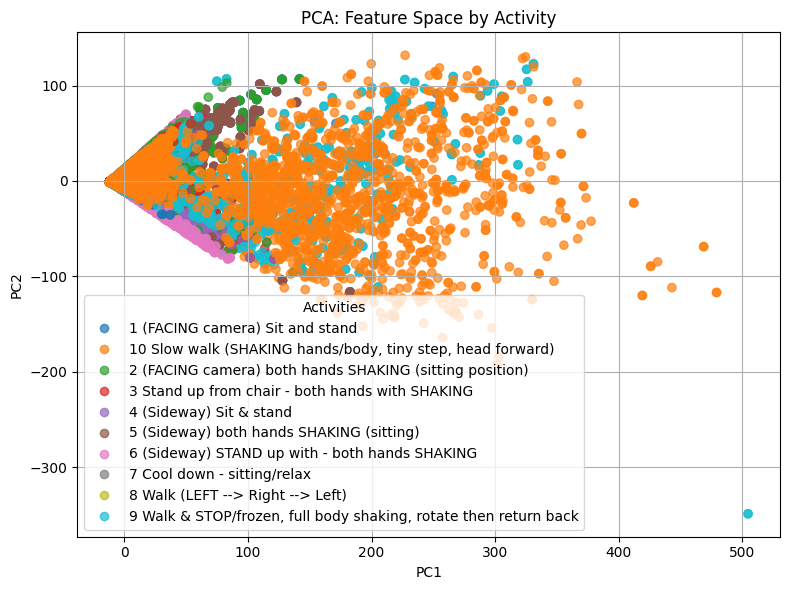

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode categorical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
legend_labels = le.classes_  # Get original activity names

# Step 2: Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 3: Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='tab10', alpha=0.7)

# Step 4: Custom legend with original activity names
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Activities")

plt.title("PCA: Feature Space by Activity")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# t-SNE

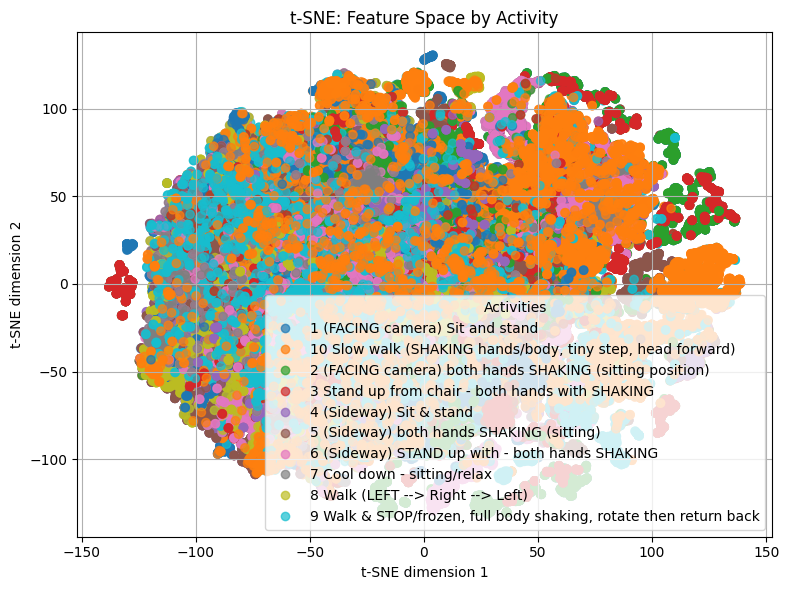

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Assume X and y are already defined (your features and labels)

# Step 1: Encode categorical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
legend_labels = le.classes_  # Original activity names

# Step 2: Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 3: Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='tab10', alpha=0.7)

# Step 4: Custom legend with original activity names
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Activities")

plt.title("t-SNE: Feature Space by Activity")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot functions

In [12]:
# for ploting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_predict, y_test, custom_msg):
    # compute confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_predict)
    # Plot with seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{custom_msg} Confusion Matrix')
    plt.show()

# Random forest

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.19      0.10      0.13      2165
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.34      0.38      0.36      3685
         2 (FACING camera) both hands SHAKING (sitting position)       0.08      0.06      0.07      1885
                 3 Stand up from chair - both hands with SHAKING       0.10      0.19      0.13      1628
                                         4 (Sideway) Sit & stand       0.01      0.00      0.01      1233
                        5 (Sideway) both hands SHAKING (sitting)       0.06      0.02      0.03      1667
                  6 (Sideway) STAND up with - both hands SHAKING       0.10      0.06      0.07      2320
                                     7 Cool down - sitting/relax       0.06      0.01      0.01       532
                                8 Walk (LEFT 

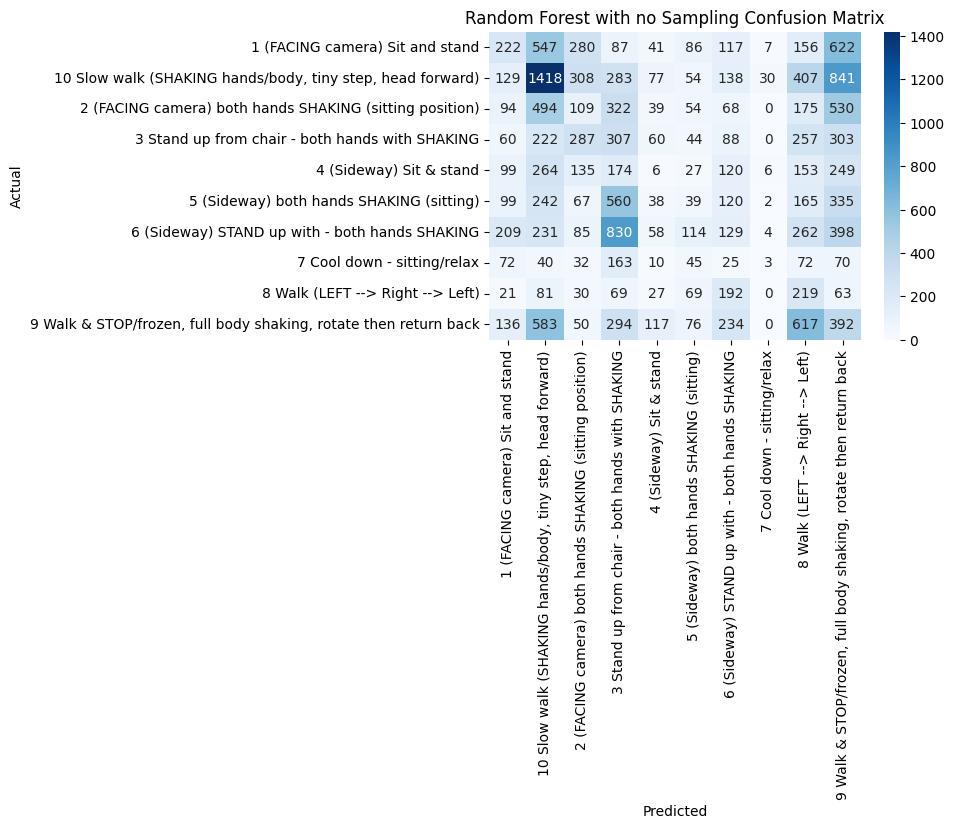

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
# rfc.fit(X_resampled, y_resampled)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

# show results
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict, 'Random Forest with no Sampling')

# Extra Trees

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.21      0.10      0.13      2165
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.31      0.40      0.35      3685
         2 (FACING camera) both hands SHAKING (sitting position)       0.09      0.06      0.07      1885
                 3 Stand up from chair - both hands with SHAKING       0.10      0.16      0.12      1628
                                         4 (Sideway) Sit & stand       0.01      0.00      0.00      1233
                        5 (Sideway) both hands SHAKING (sitting)       0.07      0.02      0.03      1667
                  6 (Sideway) STAND up with - both hands SHAKING       0.10      0.04      0.05      2320
                                     7 Cool down - sitting/relax       0.07      0.00      0.01       532
                                8 Walk (LEFT 

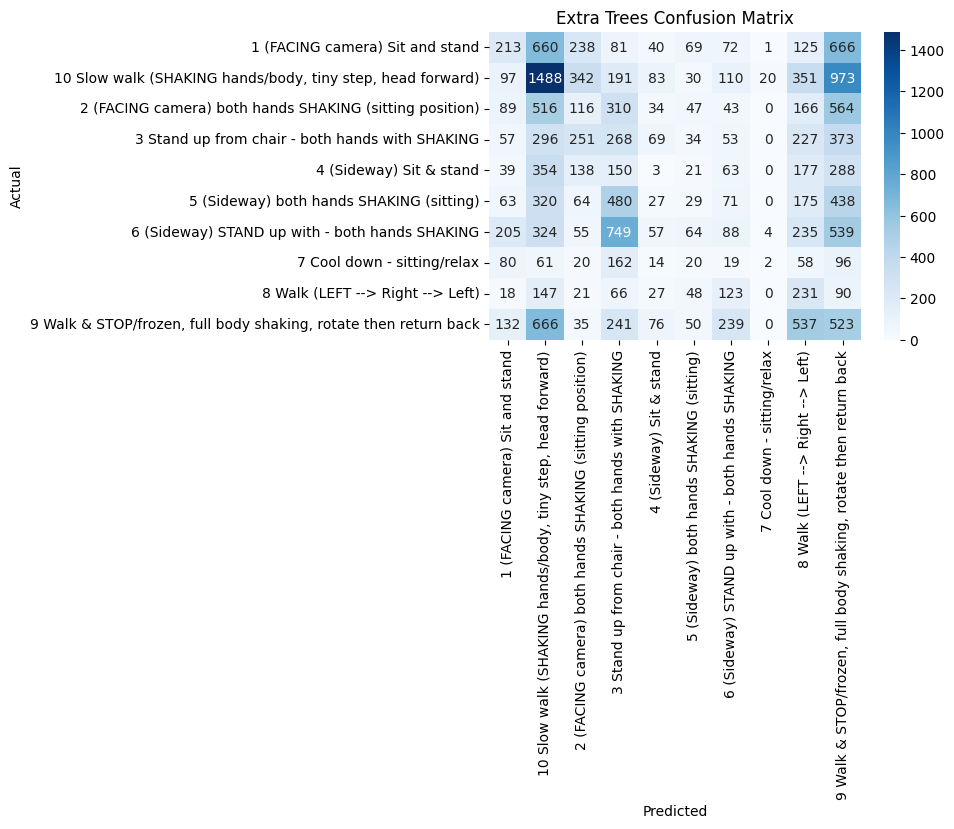

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
# etc.fit(X_resampled, y_resampled)
etc.fit(X_train, y_train)
y_predict = etc.predict(X_test)

# show results
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict, 'Extra Trees')

# Support Vector Machine

                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.21      0.17      0.19      2165
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.49      0.20      0.29      3685
         2 (FACING camera) both hands SHAKING (sitting position)       0.14      0.14      0.14      1885
                 3 Stand up from chair - both hands with SHAKING       0.12      0.20      0.15      1628
                                         4 (Sideway) Sit & stand       0.07      0.28      0.11      1233
                        5 (Sideway) both hands SHAKING (sitting)       0.09      0.04      0.05      1667
                  6 (Sideway) STAND up with - both hands SHAKING       0.00      0.00      0.00      2320
                                     7 Cool down - sitting/relax       0.00      0.00      0.00       532
                                8 Walk (LEFT 

/Users/tptn/MachineLearning/tremor_challenge2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tptn/MachineLearning/tremor_challenge2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tptn/MachineLearning/tremor_challenge2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

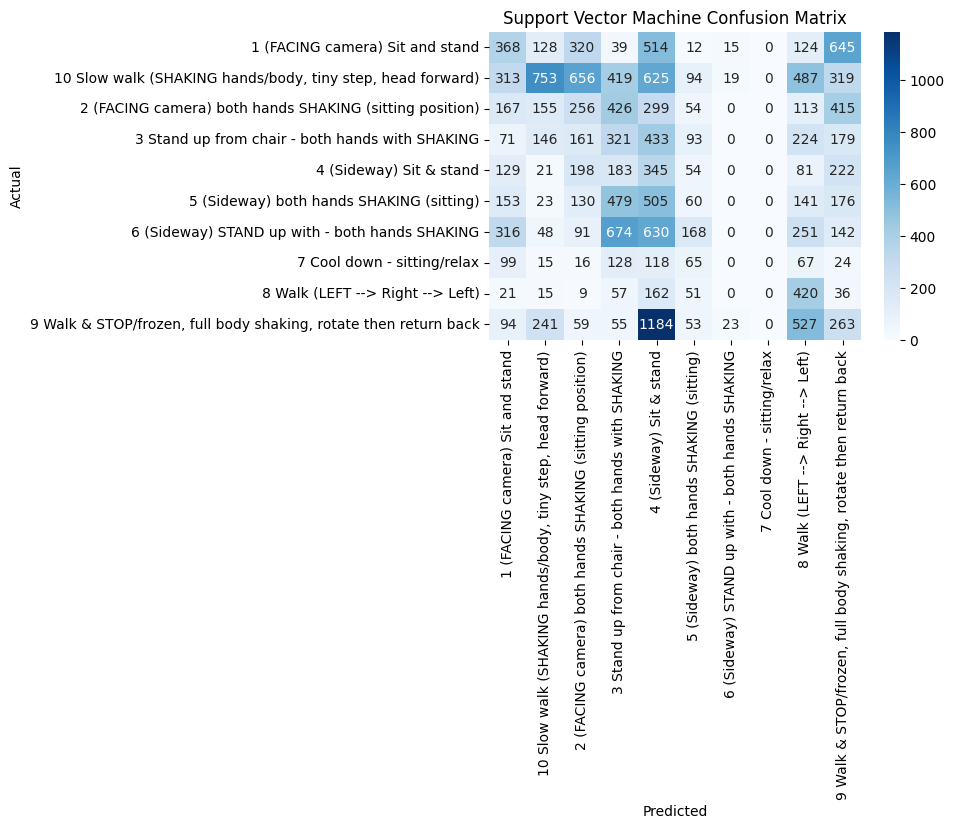

In [17]:
# Support Vector Machine
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svc = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)

print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict, 'Support Vector Machine')

# XGBoost Classifier

In [8]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)
# train on XGBClassifier
model = xgb.XGBClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Predict and print accuracy
y_pred = model.predict(X_test)
# Decode prediction back to string labels
pred_labels = label_encoder.inverse_transform(y_pred)
test_labels = label_encoder.inverse_transform(y_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5994772950016335


                                                                  precision    recall  f1-score   support

                                 1 (FACING camera) Sit and stand       0.68      0.71      0.70       949
      10 Slow walk (SHAKING hands/body, tiny step, head forward)       0.80      0.74      0.77      1329
         2 (FACING camera) both hands SHAKING (sitting position)       0.58      0.57      0.57       977
                 3 Stand up from chair - both hands with SHAKING       0.55      0.54      0.54       965
                                         4 (Sideway) Sit & stand       0.40      0.43      0.41       822
                        5 (Sideway) both hands SHAKING (sitting)       0.41      0.43      0.42       914
                  6 (Sideway) STAND up with - both hands SHAKING       0.52      0.54      0.53       918
                                     7 Cool down - sitting/relax       0.06      0.05      0.05       318
                                8 Walk (LEFT 

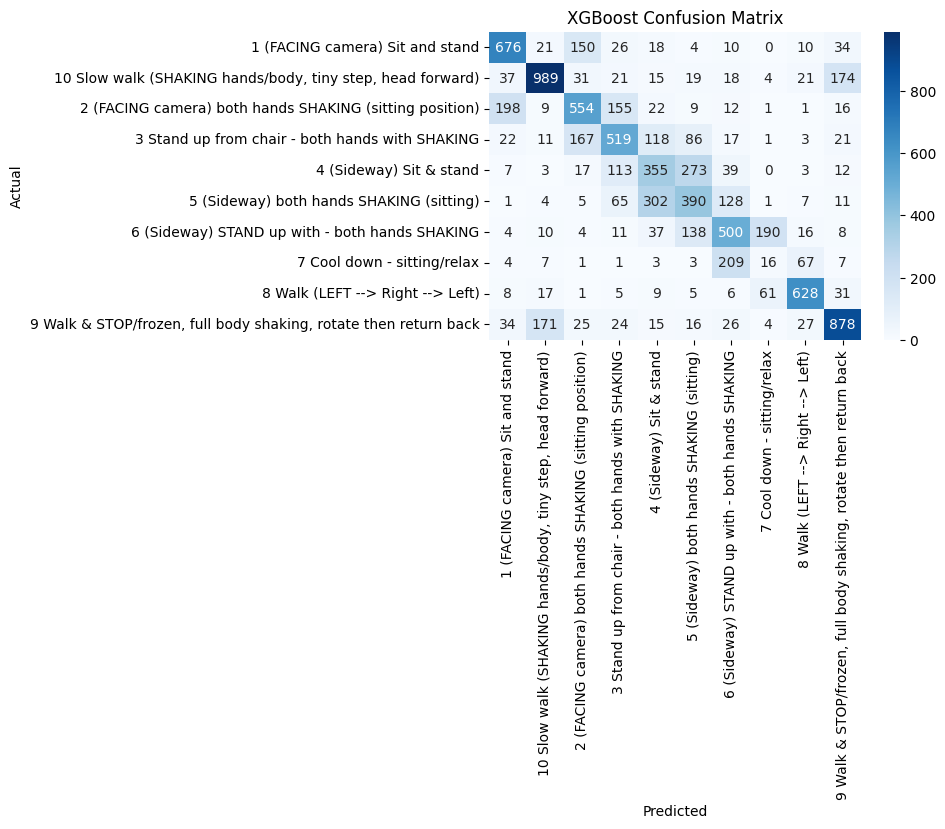

In [13]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_labels))
plot_confusion_matrix(pred_labels, test_labels, 'XGBoost')

In [14]:
# Feature names
feature_names = [
    # For each axis (x, y, z): 12 features
    *[f"{axis}_{feat}" for axis in ['x', 'y', 'z'] for feat in [
        'std', 'mean', 'max', 'min', 'median', 'iqr',
        'var', 'skew', 'kurtosis', 'ptp', 'rms', 'zcr'
    ]],
    # SMA
    "sma",
    # Axis correlations
    "corr_xy", "corr_yz", "corr_zx",
    # Tremor band energy (x, y, z)
    "tremor_energy_x", "tremor_energy_y", "tremor_energy_z",
    "tremor_energy_total"
]
# Convert X back to DataFrame for SHAP
X = pd.DataFrame(X, columns=feature_names)
X.columns = feature_names

In [15]:
import shap

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 16%|===                 | 71312/459110 [316:24<1720:35]       

: 

: 

In [ ]:
# Plot a beeswarm for each class
class_names = model.classes_ 
for i, class_name in enumerate(class_names):
    print(f"\nSHAP summary for activity class {i}: {class_name}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=30)

# Lazy predict

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test) # without resampling
# models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test) # with resampling

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10506
[LightGBM] [Info] Number of data points in the train set: 36728, number of used features: 44
[LightGBM] [Info] Start training from score -2.266961
[LightGBM] [Info] Start training from score -1.932066
[LightGBM] [Info] Start training from score -2.244616
[LightGBM] [Info] Start training from score -2.253131
[LightGBM] [Info] Start training from score -2.396970
[LightGBM] [Info] Start training from score -2.311830
[LightGBM] [Info] Start training from score -2.308812
[LightGBM] [Info] Start training from score -3.355898
[LightGBM] [Info] Start training from score -2.497621
[LightGBM] [Info] Start training from score -2.010841
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                     

# Make prediction

In [77]:
test_df = read_act_df('/Users/tptn/MachineLearning/tremor_challenge2/tremor_challenge2/data/TestingDataMay27/TestActivities-20240920.csv')
test_df = add_duration(test_df)

In [78]:
def seg_test_per_act(acc_df, test_df):
    seg_list=[]
    seg_id_list=[]
    seg_subject_list=[]

    for index, row in test_df.iterrows():
        start = row['Started']
        end = row['Finished']

        seg = acc_df[acc_df['datetime'].between(start, end)]
        seg_id = row['ID']
        seg_subject = row['Subject']
        if not seg.empty:
            seg_list.append(seg)
            seg_id_list.append(seg_id)
            seg_subject_list.append(seg_subject)

    return seg_list, seg_id_list, seg_subject_list

seg_list, seg_id_list, seg_subject_list = seg_test_per_act(users_df, test_df)

In [79]:
feats_list = []
for i, seg in enumerate(seg_list):
    feats = get_feats(seg)
    feats_list.append(feats)
    if len(seg['x']) <2:
        print(f'segment {i} column x has less than 2 data points. Something is wrong.')
    if len(seg['y']) <2:
        print(f'segment {i} column y has less than 2 data points. Something is wrong.')
    if len(seg['z']) <2:
        print(f'segment {i} column z has less than 2 data points. Something is wrong.')

In [80]:
X = np.array(feats_list)
# extra tress
# y_predict = etc.predict(X)
# random forest
y_predict = rfc.predict(X)

In [81]:
orig_test_df = pd.read_csv('/Users/tptn/MachineLearning/tremor_challenge2/tremor_challenge2/data/TestingDataMay27/TestActivities-20240920.csv')
y_predict_df = pd.DataFrame(y_predict)
y_predict_df['ID'] = seg_id_list

output_df = pd.merge(orig_test_df, y_predict_df, on='ID', how='left')
output_df.rename(columns={0: 'output'}, inplace=True)
output_df.to_csv('output/random_forest_7and3split.csv', index=False)

# Count

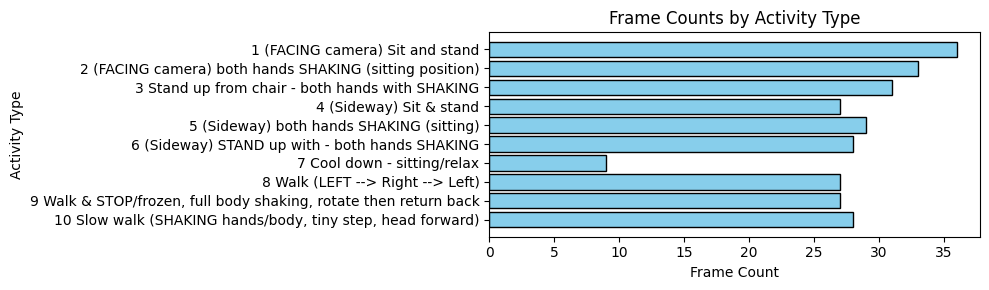

In [19]:
import matplotlib.pyplot as plt
import re

def plot_frame_counts_by_activity_type(act_df, label_col='Activity Type', title='Frame Counts by Activity Type'):
    activity_counts = act_df[label_col].value_counts()

    counts_df = activity_counts.reset_index()
    counts_df.columns = [label_col, 'count']
    counts_df['label_num'] = counts_df[label_col].apply(lambda x: int(re.match(r'\d+', str(x)).group()) if re.match(r'\d+', str(x)) else -1)
    counts_df.sort_values('label_num', ascending=False, inplace=True)

    # グラフ描画
    plt.figure(figsize=(10, 3))
    plt.barh(counts_df[label_col], counts_df['count'], color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Frame Count')
    plt.ylabel('Activity Type')
    plt.tight_layout()
    plt.show()
plot_frame_counts_by_activity_type(act_df)

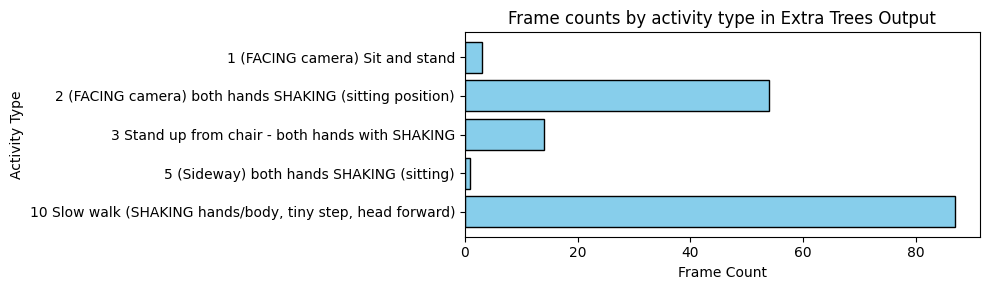

In [20]:
extra_trees_df = pd.read_csv('output/extra_trees.csv')
plot_frame_counts_by_activity_type(extra_trees_df, label_col='output', title='Frame counts by activity type in Extra Trees Output')

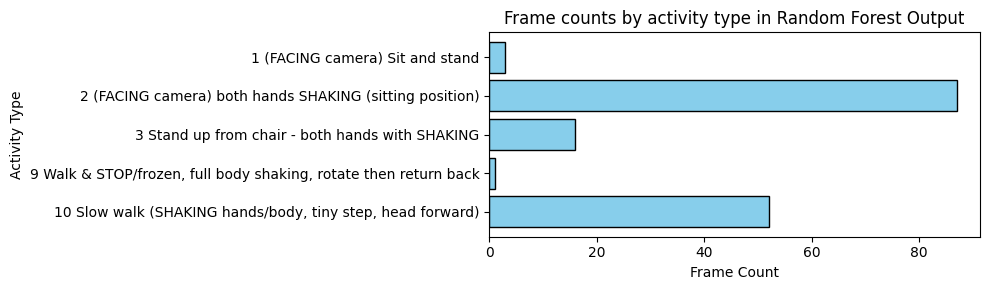

In [21]:
random_forest_df = pd.read_csv('output/random_forest_7and3split.csv')
plot_frame_counts_by_activity_type(random_forest_df, label_col='output', title='Frame counts by activity type in Random Forest Output')